# Step 1: Load libraries and data

In [1]:
import pandas as pd
import json
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from psycopg2 import sql

In [2]:
file_path = "./citi_bike.json"

# Step 1: Load multiple JSON objects line by line
data = []
with open(file_path, 'r') as file:
    for line in file:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

# Step 2: Connect to MongoDB

In [46]:
print(data[:5])

[{'num_docks_available': 4, 'num_bikes_disabled': 2, 'num_scooters_available': 0.0, 'is_installed': 1, 'num_ebikes_available': 23, 'num_scooters_unavailable': 0.0, 'eightd_has_available_keys': False, 'is_renting': 1, 'is_returning': 1, 'num_docks_disabled': 0, 'num_bikes_available': 41, 'station_id': '66dd46a2-0aca-11e7-82f6-3863bb44ef7c', 'last_reported': 1730979279000, 'legacy_id': 3150, 'name': 'E 85 St & York Ave', 'lat': 40.77536905, 'lon': -73.94803392}, {'num_docks_available': 11, 'num_bikes_disabled': 0, 'num_scooters_available': 0.0, 'is_installed': 1, 'num_ebikes_available': 4, 'num_scooters_unavailable': 0.0, 'eightd_has_available_keys': False, 'is_renting': 1, 'is_returning': 1, 'num_docks_disabled': 0, 'num_bikes_available': 11, 'station_id': '18a2cbb6-91f2-4393-82fb-b40a8ba90f20', 'last_reported': 1730979285000, 'legacy_id': 4062, 'name': 'Amsterdam Ave & W 175 St', 'lat': 40.844044, 'lon': -73.933651}, {'num_docks_available': 0, 'num_bikes_disabled': 2, 'num_scooters_ava

In [47]:

client = MongoClient('mongodb://localhost:27017/')
database = client['station_db']
collection = database['station_status']

# Comnnect to MongoDB example
# client = MongoClient("mongodb://%s:%s@127.0.0.1" % ("<username>", "<password>"))
# database = client['station_db']
# collection = database['station_status']


# Ensure that each station has a 'name'. If 'name' is missing, set it to 'Unknown Station'.
for station in data:
    if 'name' not in station or not station['name']:
        station['name'] = 'Unknown Station'  # Replace missing names with a default value

# Remove the '_id' field from each document before inserting to avoid conflict
for station in data:
    if '_id' in station:
        del station['_id']

# Insert the JSON data into MongoDB
insert_result = collection.insert_many(data)
print(f"Inserted {len(insert_result.inserted_ids)} records into MongoDB.")

# Fetch data from MongoDB
stations_data = collection.find()
stations_list = list(stations_data)

if stations_list:
    print(f"Fetched {len(stations_list)} records from MongoDB.")
    stations_dataframe = pd.DataFrame(stations_list)
else:
    print("No data found in MongoDB!")

# Handle missing name values in the DataFrame (if any still exist after insertion)
stations_dataframe['name'] = stations_dataframe['name'].fillna('Unknown Station')

# Display the columns and first few rows
print(stations_dataframe.columns)
print(stations_dataframe.head())

Inserted 2226 records into MongoDB.
Fetched 2226 records from MongoDB.
Index(['_id', 'num_docks_available', 'num_bikes_disabled',
       'num_scooters_available', 'is_installed', 'num_ebikes_available',
       'num_scooters_unavailable', 'eightd_has_available_keys', 'is_renting',
       'is_returning', 'num_docks_disabled', 'num_bikes_available',
       'station_id', 'last_reported', 'legacy_id', 'name', 'lat', 'lon'],
      dtype='object')
                        _id  num_docks_available  num_bikes_disabled  \
0  675b71edb03fc96b03a1b01f                    4                   2   
1  675b71edb03fc96b03a1b020                   11                   0   
2  675b71edb03fc96b03a1b021                    0                   2   
3  675b71edb03fc96b03a1b022                    0                   0   
4  675b71edb03fc96b03a1b023                   18                   0   

   num_scooters_available  is_installed  num_ebikes_available  \
0                     0.0             1                  

# (ETL Processing)
# Step 3: Data Transformation 

In [48]:
def process_data(stations_list):
    processed_data = []

    for station in stations_list:
        processed_station = {
            "station_id": station.get("station_id"),
            "name": station.get("name", "Unknown"),
            "lat": station.get("lat", 0),  
            "lon": station.get("lon", 0),  
            "num_bikes_available": station.get("num_bikes_available", 0),
            "num_docks_available": station.get("num_docks_available", 0),
            "is_installed": station.get("is_installed", 0) == 1
        }
        processed_data.append(processed_station)

    return processed_data

# Process the data and convert it into a DataFrame
processed_data = process_data(stations_list)
stations_dataframe = pd.DataFrame(processed_data)

In [49]:
stations_dataframe

,station_id,name,lat,lon,num_bikes_available,num_docks_available,is_installed
0,66dd46a2-0aca-11e7-82f6-3863bb44ef7c,E 85 St & York Ave,40.775369,-73.948034,41,4,True
1,18a2cbb6-91f2-4393-82fb-b40a8ba90f20,Amsterdam Ave & W 175 St,40.844044,-73.933651,11,11,True
2,1860189650739626488,E 188 St & Hughes Ave,40.856100,-73.886250,19,0,True
3,69717638-5c4a-47a7-bccb-3b42c81eb09f,56 Dr & 61 St,40.723680,-73.904580,19,0,True
4,c4e9905f-457b-4be0-a878-2aa53fa0b09b,Hart St & Wyckoff Ave,40.704876,-73.919911,5,18,True
...,...,...,...,...,...,...,...
2221,66dddc08-0aca-11e7-82f6-3863bb44ef7c,Columbus Drive,40.718355,-74.038914,1,13,True
2222,66ddddb4-0aca-11e7-82f6-3863bb44ef7c,Monmouth and 6th,40.725685,-74.048790,12,2,True
2223,bd6f422b-d7ae-4d7e-9261-653fdd8e6888,12 St & Sinatra Dr N,40.750604,-74.024020,23,1,True
2224,5faf99b8-9046-450f-9d2a-d13279b3d016,Hoboken Ave at Monmouth St,40.735208,-74.046964,30,0,True


# Step 4: Connect to PostgreSQL

In [50]:
# Step 3: Connect to PostgreSQL
try:
    conn = psycopg2.connect(
        dbname="postgres",
        user="postgres",
        password="mysecretpassword",
        host="localhost",
        port="5432"
    )
    # conn = psycopg2.connect(
    #     dbname="<dbname>",    # Replace with your database name
    #     user="<username>",         # Replace with your username
    #     password="<password>",     # Replace with your password
    #     host="localhost",
    #     port="5432"
    # )
    print("Connected to PostgreSQL")
except Exception as e:
    print(f"Error connecting to PostgreSQL: {e}")
    exit()

Connected to PostgreSQL


# Step 5: Create a table in PostgreSQL to store the transformed data

In [51]:
create_table_query = '''
CREATE TABLE IF NOT EXISTS citibike_stations (
    station_id VARCHAR PRIMARY KEY,
    name VARCHAR,
    lat FLOAT,
    lon FLOAT,
    num_bikes_available INT,
    num_docks_available INT,
    is_installed BOOLEAN
);
'''

cursor = conn.cursor()
try:
    cursor.execute(create_table_query)
    conn.commit()  # Ensure the table creation is committed
    print("Table created successfully.")
except Exception as e:
    print(f"Error creating table: {e}")
    conn.rollback()

Table created successfully.


# Step 6: Insert transformed data into PostgreSQL

In [52]:
insert_query = '''
INSERT INTO citibike_stations (station_id, name, lat, lon, num_bikes_available, num_docks_available, is_installed)
VALUES (%s, %s, %s, %s, %s, %s, %s)
ON CONFLICT (station_id) DO NOTHING;
'''

try:
    # Iterate through the DataFrame and insert data into PostgreSQL
    for _, row in stations_dataframe.iterrows():
        cursor.execute(insert_query, (
            row['station_id'],
            row['name'],
            row['lat'],
            row['lon'],  
            row['num_bikes_available'],
            row['num_docks_available'],
            row['is_installed']
        ))
    conn.commit()
    print("Data inserted into PostgreSQL successfully.")
except Exception as e:
    print(f"Error inserting data into PostgreSQL: {e}")
    conn.rollback()

Data inserted into PostgreSQL successfully.


# Step 7: Perform visualization

In [53]:
# Example: Find stations with the most available bikes
top_stations = stations_dataframe[['name', 'station_id', 'num_bikes_available']].sort_values(by='num_bikes_available', ascending=False).head(10)
print("Top 10 stations by number of bikes available:")
print(top_stations)

Top 10 stations by number of bikes available:
                                   name                            station_id  \
875                 FDR Drive & E 35 St  66dc7659-0aca-11e7-82f6-3863bb44ef7c   
2065              West St & Chambers St  66dc0e99-0aca-11e7-82f6-3863bb44ef7c   
1649               Allen St & Hester St                   1960020817312746312   
854                    W 43 St & 10 Ave  66dc7de9-0aca-11e7-82f6-3863bb44ef7c   
71                       E 6 St & Ave B  66db76a1-0aca-11e7-82f6-3863bb44ef7c   
390                    W 59 St & 10 Ave  66dc0dab-0aca-11e7-82f6-3863bb44ef7c   
547                      1 Ave & E 6 St  c37931bb-8571-4671-a9a8-f3cf23897680   
1349                     E 2 St & Ave B  66db6aae-0aca-11e7-82f6-3863bb44ef7c   
1505  Grand St & Samuel Dickstein Plaza  8cb0375d-bcb2-4c90-9773-41c3c8fdf8d8   
688                       48 Ave & 5 St  66dd243c-0aca-11e7-82f6-3863bb44ef7c   

      num_bikes_available  
875                   118  
2065  

In [54]:
stations_dataframe = stations_dataframe.dropna(subset=['num_bikes_available'])
stations_dataframe = stations_dataframe.drop_duplicates(subset=['station_id'])

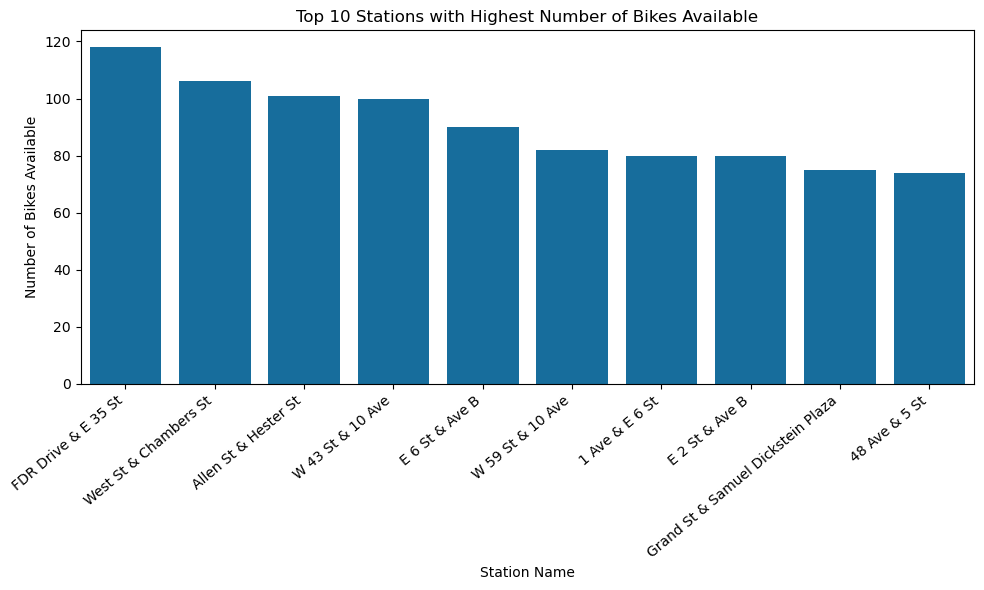

In [55]:
# Set the color-blind-friendly palette
sns.set_palette("colorblind")

# Example 1: Bar plot of top 10 stations with the highest number of available bikes (color-blind-friendly)
plt.figure(figsize=(10,6))
top_stations = stations_dataframe[['name', 'num_bikes_available']].sort_values(by='num_bikes_available', ascending=False).head(10)
sns.barplot(x='name', y='num_bikes_available', data=top_stations)
plt.title("Top 10 Stations with Highest Number of Bikes Available")
plt.xlabel('Station Name')  # Change label to 'Station Name' for better clarity
plt.ylabel('Number of Bikes Available')
plt.xticks(rotation=40, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

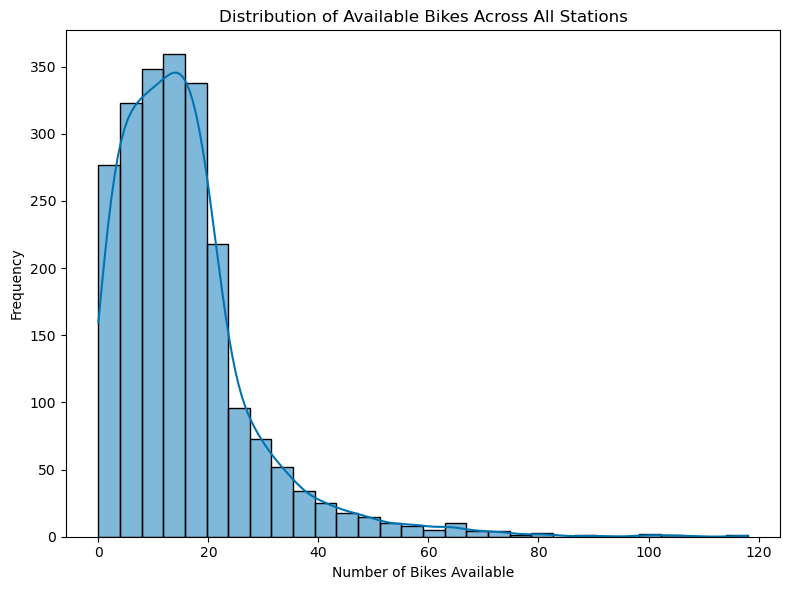

In [56]:
# Example 2: Distribution of number of available bikes across all stations (color-blind-friendly)
sns.set_palette("colorblind")
plt.figure(figsize=(8,6))
sns.histplot(stations_dataframe['num_bikes_available'], bins=30, kde=True)
plt.title("Distribution of Available Bikes Across All Stations")
plt.xlabel("Number of Bikes Available")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

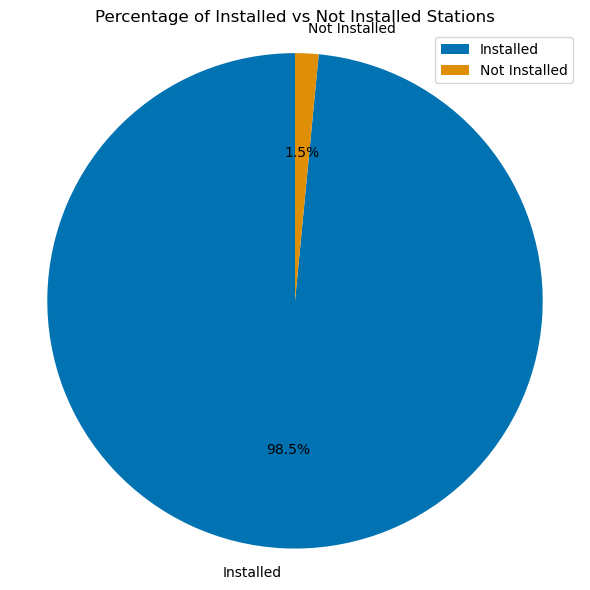

In [57]:
# Example 3: Pie chart showing installed vs. not installed stations (color-blind-friendly)
installed_counts = stations_dataframe['is_installed'].value_counts()
# Define labels for the pie chart
labels = ['Installed', 'Not Installed']
plt.figure(figsize=(6,6))
plt.pie(installed_counts, labels=["Installed", "Not Installed"], autopct='%1.1f%%', 
        colors=sns.color_palette("colorblind"), startangle=90)
plt.title("Percentage of Installed vs Not Installed Stations")
plt.axis('equal')
plt.tight_layout()
# Display a legend with the labels
plt.legend(labels, loc='upper right')
plt.show()

# Step 8: Close the database connection

In [58]:
cursor.close()
conn.close()